#### Get date and time to name save files

In [1]:
# Measure start time
import time
from datetime import date, datetime
time_start = time.strftime("%H:%M:%S", time.localtime())
today = date.today()
now = datetime.now()
DATETIME = today.strftime("%Y%m%d")+'_'+now.strftime("%H%M%S")

### User inputs

#### 0 - Name experiment

In [ ]:
# Define experiment name
experiment_name = 'medBIT_r3_ft_QA'

#### 1 - Load answers from file?

In [2]:
# To save time, give the possibility to load pregenerated answers
load_pregenerated_answers = False

# If load_pregenerated_answers is True, specify subfolder and file with pregenerated answers
# If load_pregenerated_answers is False, you can ignore this parameter
pregenerated_answer = ''

save_folder = './Results/'
if not load_pregenerated_answers:
    # Create save folder
    from pathlib import Path
    Path(f'{save_folder}{DATETIME}').mkdir(parents=True, exist_ok=True)

#### 2 - Insert path of annotations, in Haystack format

In [3]:
# Insert path of file with answers, Haystack format
my_path = './Annotations/HBD_discharge_letters_docs/' # Change accordingly to your PC paths

#### 3 - Insert model name/path

In [4]:
# Models from HuggingFace
# model_checkpoint = 'luigisaetta/squad_it_xxl_cased_hub1'
# model_checkpoint = 'mrm8488/bert-italian-finedtuned-squadv1-it-alfa'
model_checkpoint = 'deepset/xlm-roberta-large-squad2'

# Custom models
# model_checkpoint = '/home/claudio/Downloads/medBIT-r3-plus_ft_QA/'

#### 4 - Apply HF Pipeline OR Topic Detection?

In [5]:
modalities = {
    1: "PIPELINE",
    2: "TOPIC_DETECTION"
}

choice = 2
mode = modalities[choice]

# Models for Topic Detection
if mode=='PIPELINE':
    topic_model_checkpoint = ''
elif mode=='TOPIC_DETECTION':
    topic_model_checkpoint = 'MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7'

#### 5 - Define candidate labels

In [ ]:
# Define candidate labels for topics as questions
# candidate_labels = [t[1] for t in my_questions]

# Append some default topics
# candidate_labels.append('Dati sociodemografici')
# candidate_labels.append('Varie')

# Custom candidate labels
candidate_labels = [
    'Condizione patologica',
    'Farmaci',
    'Procedure chirurgiche',
    'Dati sociodemografici',
    'Varie'
]

### Setup notebook 

In [6]:
# Utility libraries
from itertools import repeat
import json
import numpy as np
import pandas as pd

import pdfplumber
import os
from requests import get
import string
import tqdm

# Graphic libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP libraries
import torch
import transformers
from spacy.lang.it import Italian 

# Custom libraries
import my_utility as utility

### Load annotations

In [7]:
all_annotations = utility.get_annotations_file(my_path, sort=True)

### Setup pipeline

In [8]:
# Get data and questions from documents
data, paragraph, my_questions = utility.get_annotations_data(all_annotations) 

In [9]:
# Remove questions
removed_question = [2]
my_questions = utility.remove_elements(my_questions, removed_question)

In [10]:
# Show questions
my_questions

[(0, 'Qual è la condizione patologica?'),
 (1, 'Qual è l’età?'),
 (3, 'Quali farmaci sono prescritti alla dimissione?'),
 (4, 'Quali sono le procedure chirurgiche applicate?')]

### Get answers

In [12]:
if load_pregenerated_answers:
    try:
        # Load pred_answers from a previously saved file
        with open(f'{save_folder}{pregenerated_answer}', 'r') as f:
            pred_answers = json.load(f)
    except:
        print('File with pregenerated answers not found!')
else:
    # Predefine a list of empty predicted answers
    pred_answers = [[] for i in repeat(None, len(data))]
    
    # Setup QA pipeline (both modes will use it)
    QA_pipeline = utility.setup_pipeline(
        'PIPELINE', 
        model_checkpoint,
        max_ans_len=30, 
        handle_impossible_ans=True
    )
    
    for j, doc in enumerate(data):
        #################### HF PIPELINE ####################
        if mode=='PIPELINE':
            for i, q in my_questions:
                QA_input = {
                    'question': q,
                    'context': doc['context']
                }
                ans = QA_pipeline(QA_input)
                ans['answer'] = ans['answer'].strip(string.punctuation+'\n')
                pred_answers[j].append((i, ans))
        elif mode=='TOPIC_DETECTION':
            # Setup TOPIC pipeline
            topic_pipeline = utility.setup_pipeline(
                'TOPIC_DETECTION', 
                topic_model_checkpoint,
                max_ans_len=30, 
                handle_impossible_ans=True
            )
            ################## TOPIC DETECTION ##################
            # 0 - Create a dict with a key for every topic
            my_text_by_topic = {s: '' for s in candidate_labels}
            # 1 - Split text in sentences
            paragraphs = utility.split_in_sentences(doc['context'])
            # Filter out empty paragraphs
            paragraphs = [p for p in paragraphs if p!='']
            for par in paragraphs:
                # 2 - Find topic for every paragraph
                pipeline_result = topic_pipeline(par, candidate_labels, multi_label=True)
                topic = utility.get_top_topic(pipeline_result)
                # 3 - Add text to its topic
                my_text_by_topic[topic]+=f'\n{par}'
            # 4 Search answer only in specific topic
            for i, q in my_questions:
                q_topic = utility.get_top_topic(topic_pipeline(q, candidate_labels, multi_label=True))
                try: # context could be empty
                    QA_input = {
                        'question': q,
                        'context': my_text_by_topic[q_topic]
                    }
                    ans = QA_pipeline(QA_input)
                    ans['answer'] = ans['answer'].strip(string.punctuation+'\n')
                except:
                    ans = {'score': 0, 'start': 0, 'end': 0, 'answer': ''}
                pred_answers[j].append((i, ans))

In [13]:
# Save pred_answers to file to load it later, if not loaded
if not load_pregenerated_answers:
    with open(f'{save_folder}{DATETIME}/pred_answers_{DATETIME}.json', 'w') as f:
        json.dump(pred_answers, f, indent=4)

### Show results

In [14]:
# Create variables
pred_ans_for_stats = [[] for i in repeat(None, len(all_annotations))] # List of predicted answers, used to calculate results
correct_ans_for_stats = [[] for i in repeat(None, len(all_annotations))] # List of reference answers, used to calculate results

# Populate list of predicted and correct answers
# They will be used to calculate statistical parameters
for k, doc in enumerate(data):
    counter = 0
    for i, q in my_questions:
        corr_ans_index = k*(len(my_questions)+1)+i
        pred_ans_for_stats[k].append(pred_answers[k][counter][1]["answer"].lower().strip(string.punctuation+' '))
        correct_ans_for_stats[k].append(doc[f"answer_{corr_ans_index}"].lower().strip(string.punctuation+' '))
        counter+=1

In [15]:
for i in range(len(pred_ans_for_stats)):
    print('*'*50+f' Document index {i} '+'*'*50)
    for j, (ref, pred) in enumerate(zip(correct_ans_for_stats[i], pred_ans_for_stats[i])):
        print(f'Question: "{my_questions[j][1]}"')
        print(f'Reference answer: "{ref}"')
        print(f'Predicted answer: "{pred}"')
        print('^'*30)

************************************************** Document index 0 **************************************************
Question: "Qual è la condizione patologica?"
Reference answer: "stenosi valvolare aortica severa"
Predicted answer: "stenosi valvolare aortica severa"
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Question: "Qual è l’età?"
Reference answer: "74"
Predicted answer: ""
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Question: "Quali farmaci sono prescritti alla dimissione?"
Reference answer: "pantoprazolo 20 mg 1 cp ore 8 
-  clopidogrel 75 mg 1 cp dopo pranzo 
-  bisoprololo 1.25 mg 1 cp alle ore 8 e 1 cp alle ore 20 
-  ramipril 5 mg 1 cp alle ore 8 e 1 cp alle ore 20 
-  furosemide 500 mg ¼ cp alle ore 8 e ¼ alle ore 20 
-  canreonato di potassio 100 mg ½ cp alle ore 16 
-  levotiroxina 100 mcg 1 cp a digiuno alle ore 7 
-  tiotropio respimat 2 inalazioni al mattino 
-  lorazepam 1 mg 1 cp alle ore 22 
-  domperidone 1 cp a pranzo e a cena"
Predicted answer: "pantoprazolo 20 mg 1 cp ore 8 
-  clopido

### Elaborate results

#### Global results

In [16]:
results, all_TP_global, all_FP_global, all_FN_global = utility.elaborate_results_global(
    pred_ans_for_stats, 
    correct_ans_for_stats,
    all_annotations, 
    my_questions, 
    pred_answers, 
    model_checkpoint, 
    show_answers=False
)

In [17]:
print(f'GLOBAL EM = {results["EM_TOTAL"]*100:.2f}%')
print(f'GLOBAL EM (NOT EMPTY ANSWERS) = {results["EM_NOT_EMPTY_TOTAL"]*100:.2f}%')
print(f'GLOBAL P = {results["P_TOTAL"]*100:.2f}%')
print(f'GLOBAL R = {results["EM_TOTAL"]*100:.2f}%')
print(f'GLOBAL F1 WEIGHTED = {results["F1_WEIGHTED_TOTAL"]*100:.2f}%')
print(f'GLOBAL F1 MACRO = {results["F1_MACRO_TOTAL"]*100:.2f}%')

GLOBAL EM = 31.94%
GLOBAL EM (NOT EMPTY ANSWERS) = 4.40%
GLOBAL P = 76.86%
GLOBAL R = 31.94%
GLOBAL F1 WEIGHTED = 12.91%
GLOBAL F1 MACRO = 9.16%


#### By question

In [18]:
df_questions = utility.elaborate_results_by_question(
    all_TP_global, 
    all_FP_global, 
    all_FN_global
)

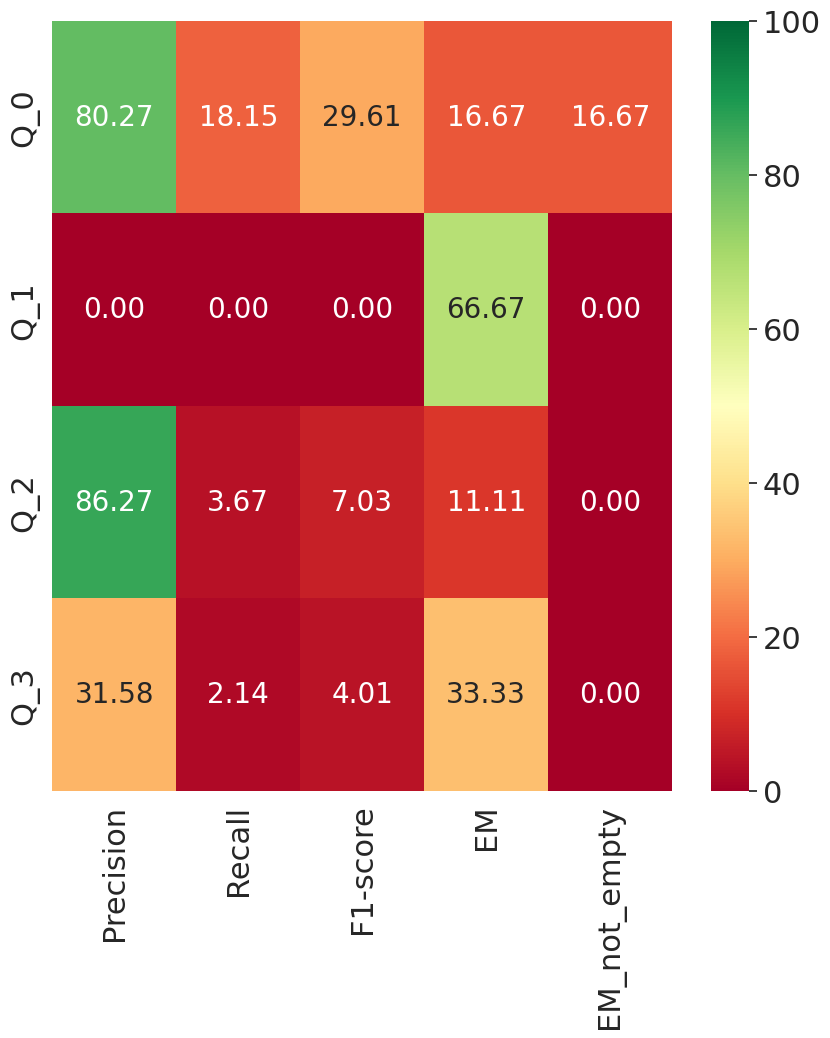

In [19]:
# Convert dataframe to heatmap, by questions
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_questions, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=100)
fig.savefig(f'{save_folder}{DATETIME}/Documents_heat_{DATETIME}.png', dpi=400, transparent=True, bbox_inches='tight')

#### By document

In [20]:
df_documents = utility.elaborate_results_by_document(
    all_TP_global, 
    all_FP_global, 
    all_FN_global
)

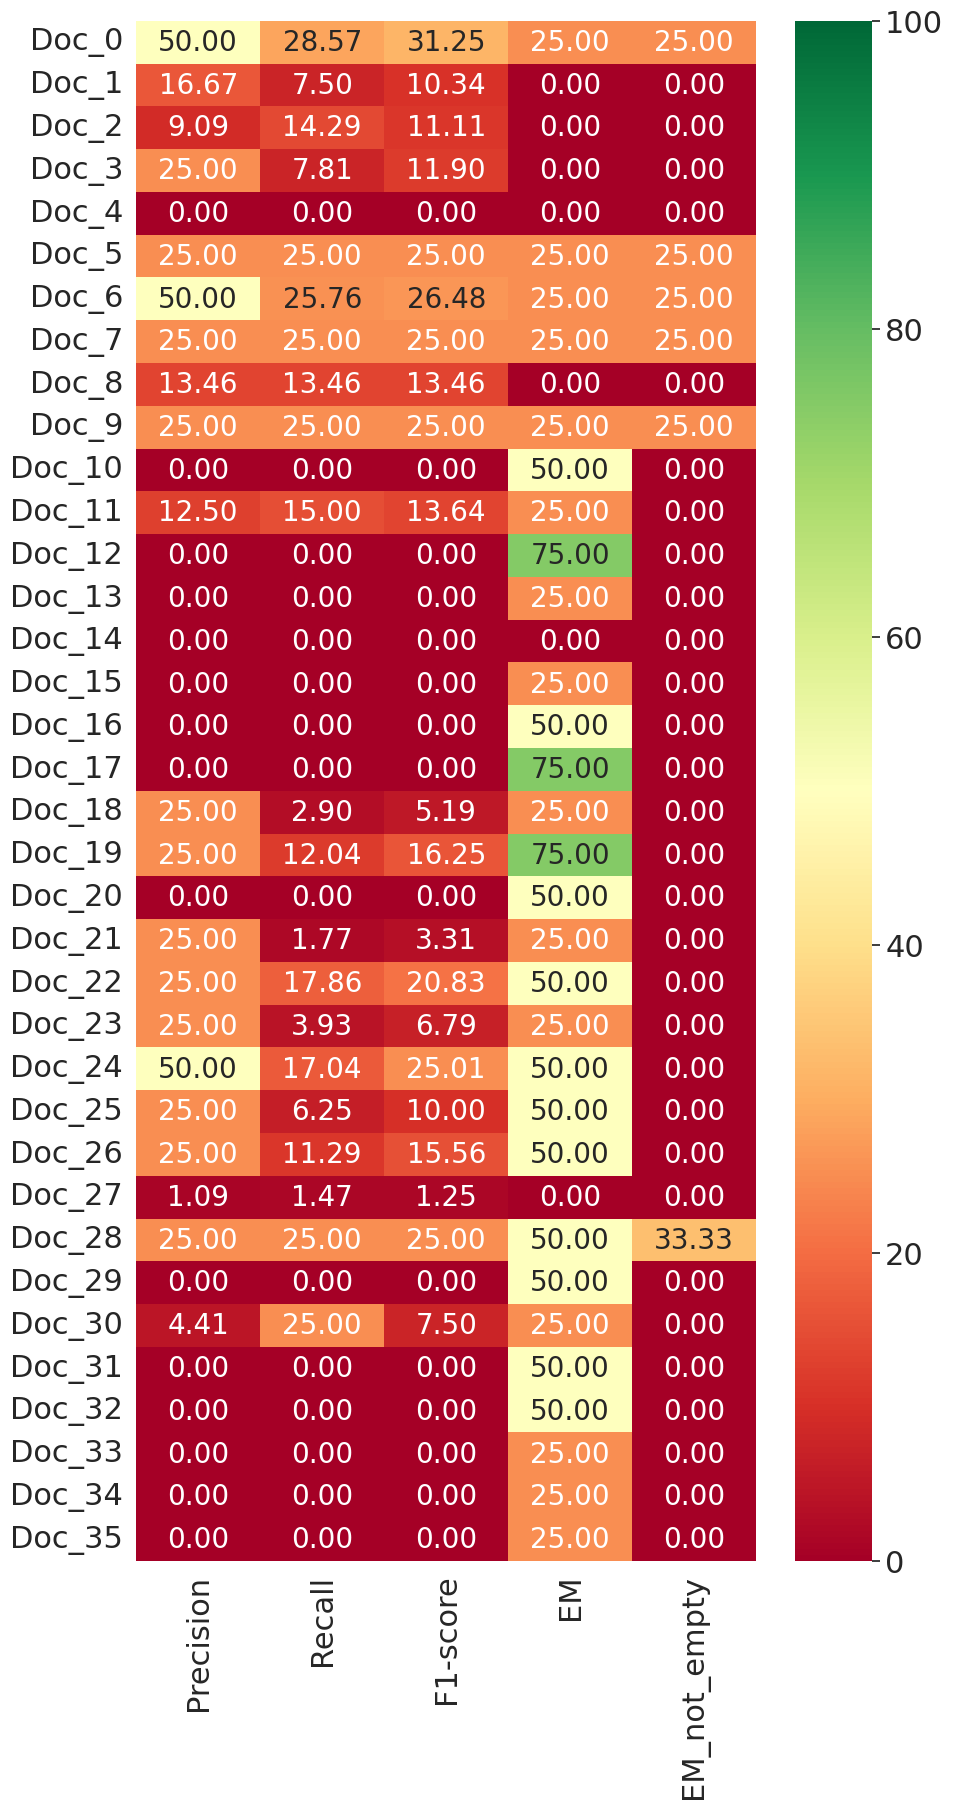

In [21]:
# Convert dataframe to heatmap, by document
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(df_documents, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=100)
fig.savefig(f'{save_folder}{DATETIME}/QUESTIONS_heat_{DATETIME}.png', dpi=400, transparent=True, bbox_inches='tight')

In [22]:
# General info
session_info = json.loads(get('https://ipinfo.io').content.decode('utf8'))
session_info['time_start'] = time_start
session_info['experiment_name'] = experiment_name
session_info['mode'] = mode
session_info['qa_checkpoint'] = model_checkpoint
if mode=='TOPIC_DETECTION':
    session_info['topic_checkpoint'] = topic_model_checkpoint
session_info['annotations'] = all_annotations
session_info['time_end'] = time.strftime("%H:%M:%S", time.localtime())

# QABot results
session_info['global_results'] = {
    'EM Score': float(f'{results["EM_TOTAL"]*100:.2f}'),
    'EM Score not empty': float(f'{results["EM_NOT_EMPTY_TOTAL"]*100:.2f}'),
    'Precision': float(f'{results["P_TOTAL"]*100:.2f}'),
    'Recall': float(f'{results["R_TOTAL"]*100:.2f}'),
    'F1-Score (weighted)': float(f'{results["F1_WEIGHTED_TOTAL"]*100:.2f}'),
    'F1-Score (macro)': float(f'{results["F1_MACRO_TOTAL"]*100:.2f}'),
}
session_info['results_by_question'] = df_questions.to_dict()
session_info['results_by_document'] = df_documents.to_dict()

with open(f'{save_folder}{DATETIME}/session_info_{DATETIME}.json', "w") as outfile:
    outfile.write(json.dumps(session_info, indent=4))

# TO TEST

### Calculate BLEU score

In [23]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [24]:
# BLEU score of all answers
# score = corpus_bleu(ref_corpus_bleu, pred_corpus_bleu)
# score = sentence_bleu(reference, candidate)
weights_list = [(1, 0, 0, 0), (1/2, 1/2, 0, 0), (1/3, 1/3, 1/3, 0), (1/4, 1/4, 1/4, 1/4)]
for index, (_, question) in enumerate(my_questions):
    print(f'Scores of question: {question}')
    ref_corpus_bleu = [[i[index].split()] for i in correct_ans_for_stats]
    pred_corpus_bleu = [i[index].split() for i in pred_ans_for_stats]
    score_list = corpus_bleu(ref_corpus_bleu, hypotheses=pred_corpus_bleu, weights=weights_list)
    for index, score in enumerate(score_list):
        print(f'Bleu score for {index+1}-grams:  {round(score, 2)*100}%')

Scores of question: Qual è la condizione patologica?
Bleu score for 1-grams:  2.0%
Bleu score for 2-grams:  2.0%
Bleu score for 3-grams:  1.0%
Bleu score for 4-grams:  1.0%
Scores of question: Qual è l’età?
Bleu score for 1-grams:  0%
Bleu score for 2-grams:  0%
Bleu score for 3-grams:  0%
Bleu score for 4-grams:  0%
Scores of question: Quali farmaci sono prescritti alla dimissione?
Bleu score for 1-grams:  0.0%
Bleu score for 2-grams:  0.0%
Bleu score for 3-grams:  0.0%
Bleu score for 4-grams:  0.0%
Scores of question: Quali sono le procedure chirurgiche applicate?
Bleu score for 1-grams:  0.0%
Bleu score for 2-grams:  0.0%
Bleu score for 3-grams:  0.0%
Bleu score for 4-grams:  0.0%
